# Dependencies

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [65]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [57]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, figsize=(15,8))  # fontsize of the figure title

# IPF Demo

## Setup

First we'll generate some data, and for any data that is lower than some minimum threshold, we'll replace it with a random seed:

In [268]:
RANGE = (1, 1000)
MIN_VALUE = 10
SIZE = (100,100)

# Generate some original data
original_data = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=SIZE))

# Any value less than MIN_VALUE is going to be suppressed.
missing_value_mask = original_data < MIN_VALUE
missing_values = original_data[missing_value_mask]

# Calculate the totals before we suppress.
column_totals = np.sum(original_data, axis=0)
row_totals = np.sum(original_data, axis=1)


# Replace the suppressed numbers with a random number in the interval [0, MIN_VALUE]
suppressed_data = np.copy(original_data)
suppressed_data[missing_value_mask] = np.rint(np.random.uniform(low=1, high=MIN_VALUE, size=missing_values.shape))

In [269]:
print(missing_values)
print(suppressed_data[missing_value_mask])

[ 9.  5.  6.  8.  8.  9.  2.  8.  3.  5.  3.  7.  9.  9.  7.  4.  6.  5.
  1.  2.  9.  3.  5.  5.  3.  6.  4.  6.  7.  6.  8.  8.  6.  6.  5.  9.
  5.  3.  3.  7.  6.  4.  4.  5.  7.  6.  7.  3.  6.  3.  2.  9.  6.  2.
  2.  2.  4.  4.  3.  1.  3.  5.  6.  5.  2.  2.  5.  3.  8.  7.  2.  3.
  7.  5.  9.  6.  2.  4.  3.  3.  4.  3.  3.  1.  9.  2.  3.  9.  2.  7.
  4.  8.  3.  6.  5.  8.  3.  8.  9.  8.  9.  3.  4.  4.]
[  6.   4.   3.   9.   9.  10.   9.   8.   7.   2.   3.   4.   7.   3.   5.
   8.   2.   2.   3.   5.   9.   8.   2.   3.   2.   7.   4.   4.   6.   5.
   6.   2.   6.   7.   4.   7.   5.   6.   9.   4.   2.   3.   2.   4.  10.
   9.   3.   9.   6.   3.   8.  10.   1.   9.   5.   9.   6.   6.  10.   9.
   2.  10.   1.  10.   4.   8.  10.   9.   6.   2.   2.   8.   8.   6.   2.
   4.  10.   2.   3.   2.   5.   4.  10.   2.   6.   1.   8.   4.   3.   6.
   8.   6.   3.   4.   5.   7.   8.   6.   6.   6.   9.   8.   4.   7.]


Let's take a look at how far off our random seeds are:

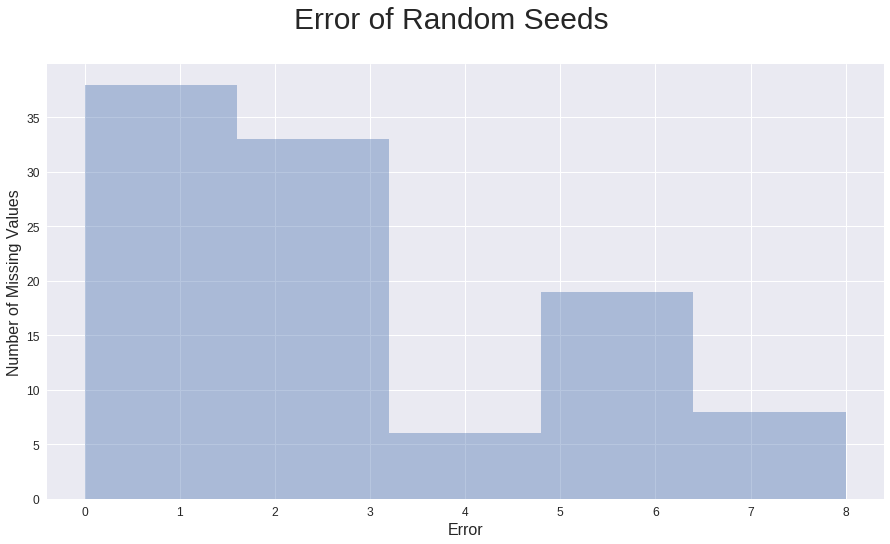

In [270]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error of Random Seeds")
plt.ylabel("Number of Missing Values")
plt.xlabel("Error")
plt.show()

In [271]:
stats.describe(errors)

DescribeResult(nobs=104, minmax=(0.0, 8.0), mean=2.7788461538461537, variance=4.8341112770724424, skewness=0.6135764169163831, kurtosis=-0.679369858774237)

## IPF

In [276]:
CONVERGENCE_THRESHOLD = 1e-3
MAX_ITERATIONS = 50000

delta = CONVERGENCE_THRESHOLD + 1
i = 0

while delta > CONVERGENCE_THRESHOLD and i < MAX_ITERATIONS:
    before = suppressed_data[missing_value_mask]
    
    current_row_totals = np.sum(suppressed_data, axis=1)
    current_column_totals = np.sum(suppressed_data, axis=0)
    
    for row in range(SIZE[0]):
        missing_indexes = missing_value_mask[row, :]    
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] / current_row_totals[row] 
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] * row_totals[row]

    for col in range(SIZE[1]):
        missing_indexes = missing_value_mask[:, col]    
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] / current_column_totals[col] 
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] * column_totals[col]    
    
    after = suppressed_data[missing_value_mask]
    delta = np.sum(np.abs(after-before))
    i += 1

How did we do?

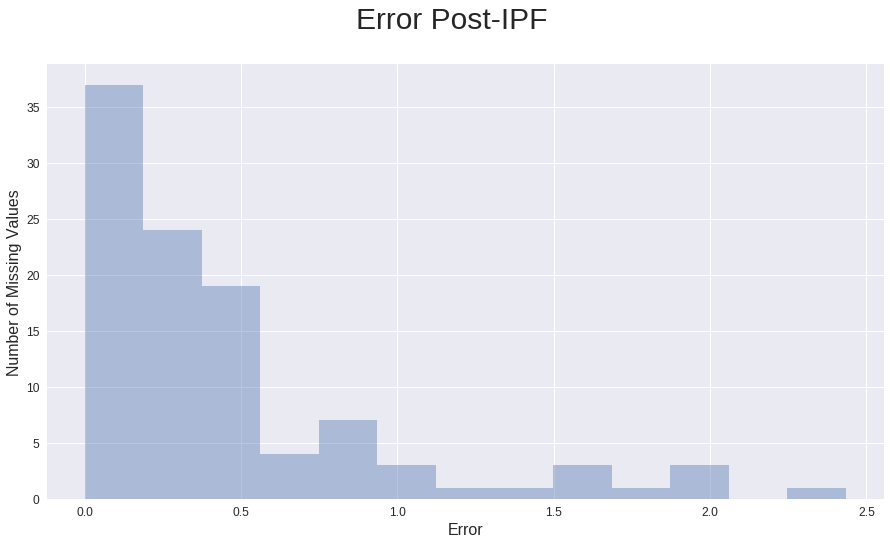

In [277]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error Post-IPF")
plt.ylabel("Number of Missing Values")
plt.xlabel("Error")
plt.show()

In [278]:
print(stats.describe(errors))
print(i)

DescribeResult(nobs=104, minmax=(4.4408920985006262e-16, 2.4335289906200441), mean=0.44344176044298433, variance=0.26098921490017585, skewness=1.8360559109149908, kurtosis=3.159653350802503)
29748


In [282]:
print(missing_values)
print(np.rint(suppressed_data[missing_value_mask]))

[ 9.  5.  6.  8.  8.  9.  2.  8.  3.  5.  3.  7.  9.  9.  7.  4.  6.  5.
  1.  2.  9.  3.  5.  5.  3.  6.  4.  6.  7.  6.  8.  8.  6.  6.  5.  9.
  5.  3.  3.  7.  6.  4.  4.  5.  7.  6.  7.  3.  6.  3.  2.  9.  6.  2.
  2.  2.  4.  4.  3.  1.  3.  5.  6.  5.  2.  2.  5.  3.  8.  7.  2.  3.
  7.  5.  9.  6.  2.  4.  3.  3.  4.  3.  3.  1.  9.  2.  3.  9.  2.  7.
  4.  8.  3.  6.  5.  8.  3.  8.  9.  8.  9.  3.  4.  4.]
[  9.   5.   6.   8.   8.  10.   2.   7.   5.   3.   3.   7.   9.   9.   7.
   4.   6.   4.   1.   2.   8.   3.   5.   5.   3.   7.   3.   6.   7.   6.
   8.   8.   6.   6.   5.  10.   5.   3.   3.   6.   5.   6.   3.   4.   9.
   6.   7.   3.   6.   3.   3.  10.   4.   2.   2.   3.   4.   4.   3.   1.
   4.   5.   4.   5.   2.   2.   6.   3.   8.   6.   2.   3.   7.   7.   7.
   6.   2.   4.   3.   2.   4.   3.   3.   1.   9.   3.   3.   9.   2.   7.
   3.   8.   3.   6.   5.   8.   4.   7.  10.   8.   9.   3.   4.   4.]
